# Starting Point

In [1]:
# upload dataset
from google.colab import files
upl = files.upload()

Saving monthly-beer-production-in-austr.csv to monthly-beer-production-in-austr.csv


In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
import xgboost as xgb

In [3]:
# read data
df = pd.read_csv('monthly-beer-production-in-austr.csv')
# display 
df.head(5)

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
# check for missing values
df.isnull().sum()

Month                      0
Monthly beer production    0
dtype: int64

Praise the heavens, no missing values...

In [5]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


Seems that the month feature is of type object instead of datetime :/

In [6]:
# change date feature to datetime and setting it as index
df['Month'] = pd.to_datetime(df['Month'])
df.head(5)

,Month,Monthly beer production
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9


After passing pandas datetime method, a day('the first') has been added. Regardless we shall continue.

Lets rename the **'Month'** feature to **Date**, that way it isnt as confusing. 

In [7]:
# rename feature
df.rename(columns={'Month': 'Date'}, inplace=True)
# display updates
df.head(5)

,Date,Monthly beer production
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9


In [8]:
# feature extraction 
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
# display new df
df.head(3)

,Date,Monthly beer production,Month,Year
0,1956-01-01,93.2,1,1956
1,1956-02-01,96.0,2,1956
2,1956-03-01,95.2,3,1956


We've extracted the year and month from the date feature.

Lets vizualize how and discover.

# Visualizations

<Axes: xlabel='Monthly beer production', ylabel='Density'>

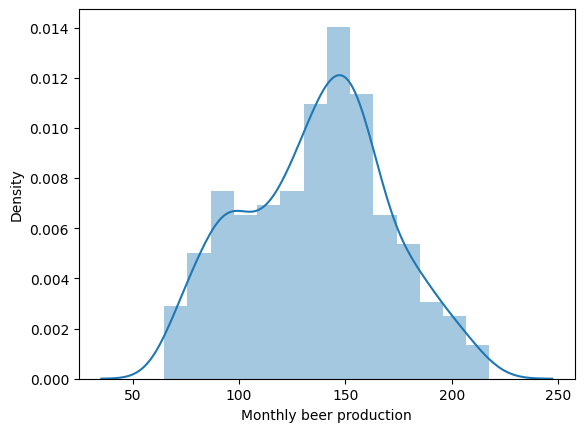

In [9]:
# lets check the distribution of beer
sns.distplot(df['Monthly beer production'])

In [10]:
# skewness and kurtosis
print("Skewness: %f" % df['Monthly beer production'].skew())
print("Kurtosis: %f" % df['Monthly beer production'].kurt())

Skewness: -0.035923
Kurtosis: -0.615760


Distribution is slighty left skewed, implying a very small variance in it.

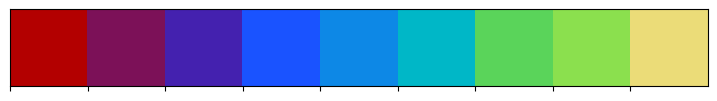

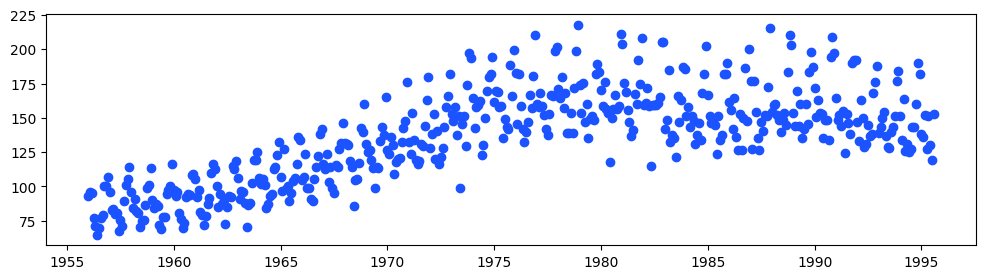

In [11]:
#  color scheme
river_nights = ["#b30000", "#7c1158", "#4421af", "#1a53ff", "#0d88e6", "#00b7c7", "#5ad45a", "#8be04e", "#ebdc78"]
# color palates
sns.palplot(river_nights)

# scatter plot of the data
plt.figure(figsize=(12,3))
plt.scatter(df['Date'],df['Monthly beer production'],color=river_nights[3])

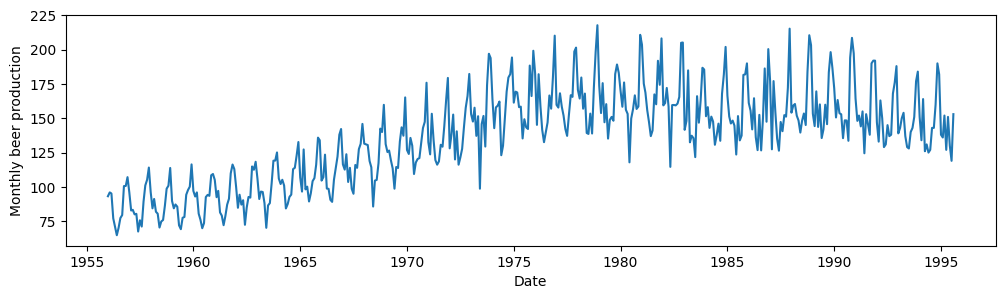

In [12]:
# line plot of data
plt.figure(figsize=(12,3))
sns.lineplot(x = df['Date'] ,y = 'Monthly beer production',data = df,palette = river_nights[3]);

From the plot, we see that the production of beer began to kick off in the mid 1960's and peaking towards the beginning of the 1980's (late 1970).

In [13]:
# peak year of beer production
df.loc[df['Monthly beer production'].idxmax() ]

Date                       1978-12-01 00:00:00
Monthly beer production                  217.8
Month                                       12
Year                                      1978
Name: 275, dtype: object

Text(0.5, 1.0, 'Monthly Beer Production ')

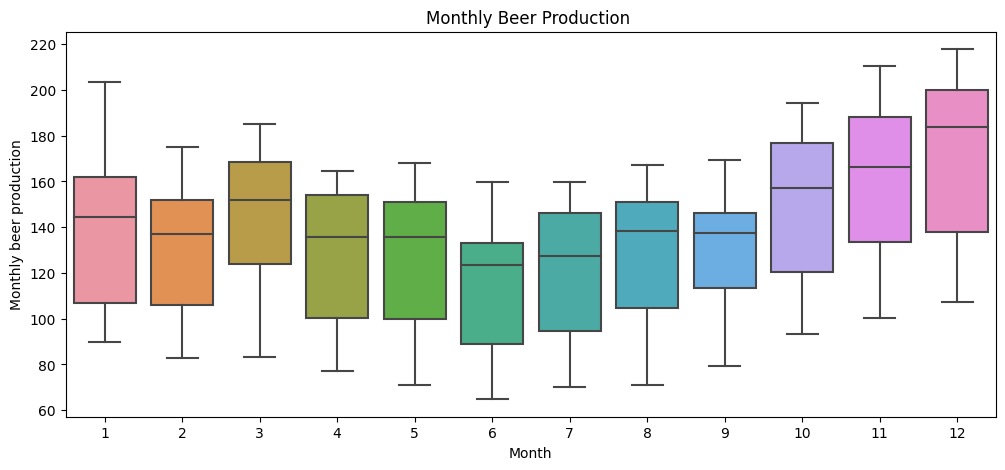

In [14]:
# Monthly beer production plot
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='Month',y='Monthly beer production')
ax.set_title('Monthly Beer Production ')

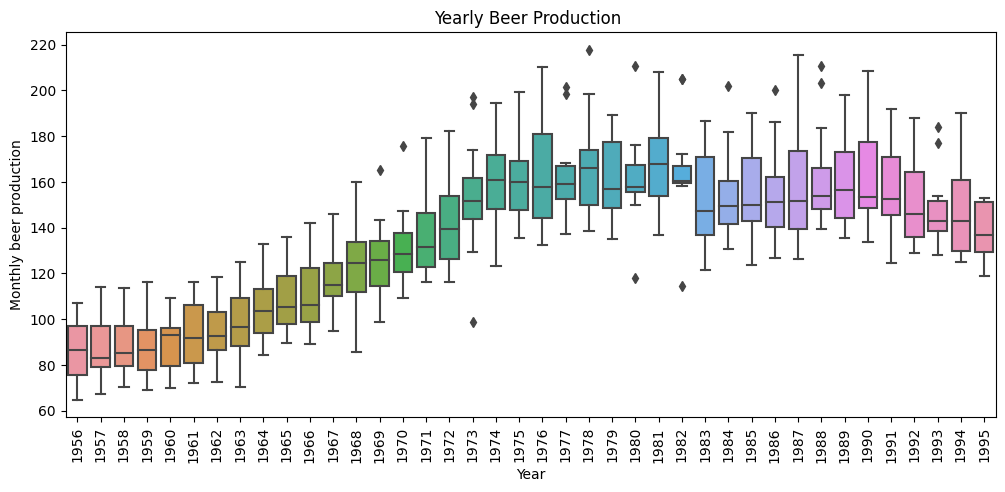

In [15]:
# Yearly beer production plot
fig, ax = plt.subplots(figsize=(12,5))
plt.xticks(rotation=90)
sns.boxplot(data=df, x='Year',y='Monthly beer production')
ax.set_title('Yearly Beer Production ')
plt.show()

## Moving Average

In [16]:
# new df with only date and beer
new_df = df.drop(columns=['Month', 'Year'])
# display new df
new_df.head(5)

,Date,Monthly beer production
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9


In [17]:
# set date as index
new_df = new_df.set_index(['Date'])
# get rolling mean and standard deviation
rolling_mean = new_df.rolling(window=12).mean()
rolling_std = new_df.rolling(window=12).std()

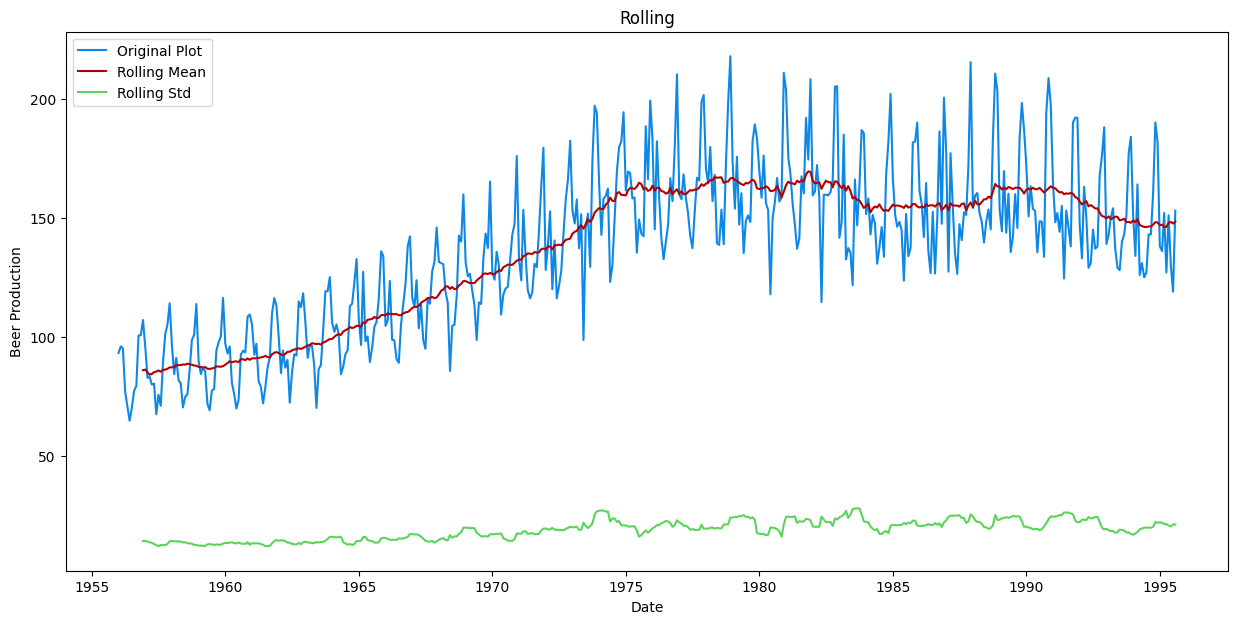

In [18]:
#plot original mean
plt.figure(figsize = (15,7))
plt.plot(new_df, color=river_nights[4], label='Original Plot')

# plot rolling mean and std
plt.plot(rolling_mean, color=river_nights[0], label='Rolling Mean')
plt.plot(rolling_std, color=river_nights[6], label='Rolling Std')

# labels
plt.xlabel('Date')
plt.ylabel('Beer Production')
plt.legend(loc = 'upper left')
plt.title('Rolling')
plt.show()

# Stationarity Check: ADF(augmented dickey fuller)

Adf Statistic: -2.282661418787577
P_value of timeseries: 0.17762099829132505
Timeseries Crit Values: {'1%': -3.4447087976702284, '5%': -2.867871300049488, '10%': -2.5701423432047443}
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


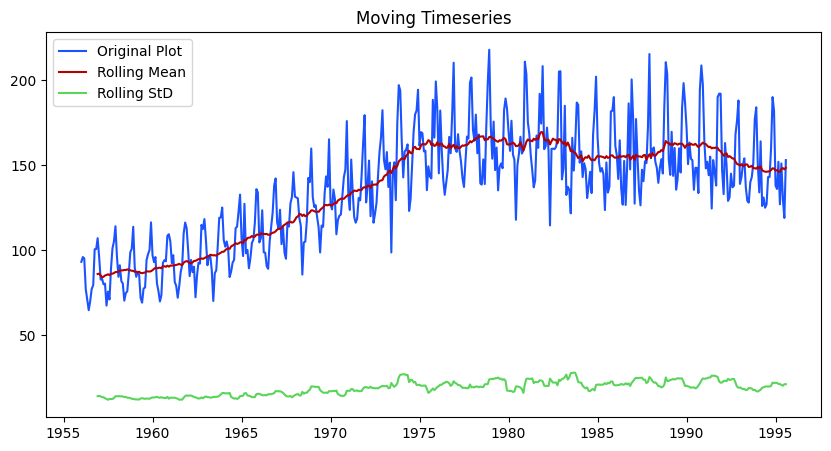

In [19]:
# function to plot and check for stationarity
def adf_tester(timeseries_data):
  # calculate the moving average and std
  movingAvg = timeseries_data.rolling(window=12).mean()
  movingStd = timeseries_data.rolling(window=12).std()

  # plot timeseires with moving avg and std
  plt.figure(figsize=(10,5))
  main_plt = plt.plot(timeseries_data, color=river_nights[3], label='Original Plot')
  mean_plt = plt.plot(movingAvg, color=river_nights[0], label= 'Rolling Mean')
  std_plt = plt.plot(movingStd, color=river_nights[6], label ='Rolling StD')
  plt.legend(loc='upper left')
  plt.title('Moving Timeseries')

  # ADF Testing
  adf = adfuller(timeseries_data) # just like that
  print('Adf Statistic:',adf[0])      # Get ADF Statistic
  print('P_value of timeseries:',adf[1])   # The p_value
  print('Timeseries Crit Values:', adf[4])    # critical values of timeseries

  # Stationarity check
  if adf[0] > adf[4]["5%"]:
    print('ADF > Critical Values')
    print("Failed to reject null hypothesis, time series is non-stationary.")
  else:
      print("ADF < Critical Values")
      print ("Reject null hypothesis, time series is stationary.")
        
# call function on data
adf_tester(new_df)

## Log Transformation: BoxCox

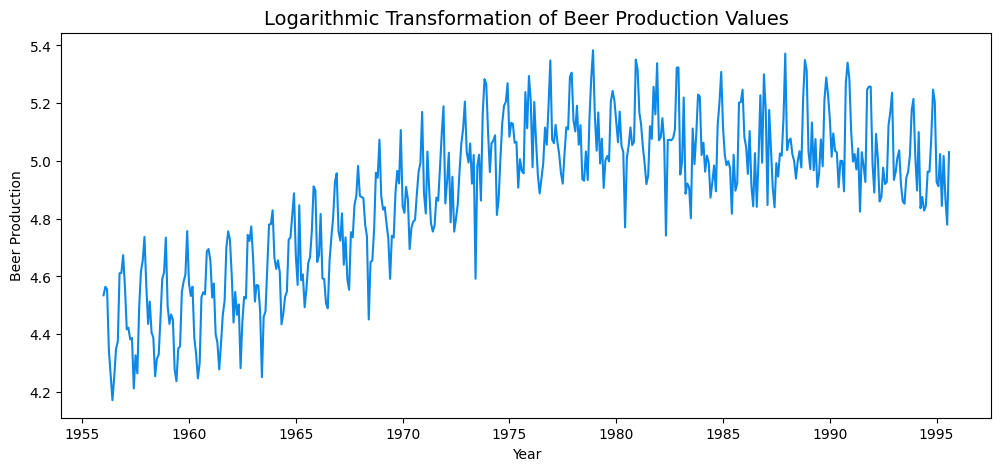

In [20]:
# create a similar dataframe for boxcox optimization
log_df = new_df
# log transform the target feature
log_df['Monthly beer production'] = boxcox(log_df['Monthly beer production'],lmbda=0.0)

# plot transformed data
plt.figure(figsize = (12,5))
plt.plot(log_df, color = river_nights[4])
plt.xlabel('Year')
plt.ylabel('Beer Production')
plt.title("Logarithmic Transformation of Beer Production Values", size = 14)
plt.show()


## Detrending by differencing

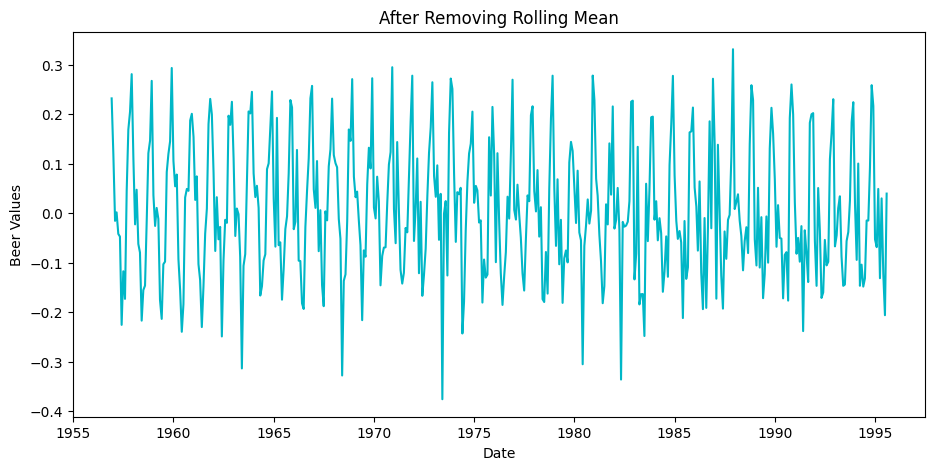

In [21]:
# get new rolling mean
rolling_mean = log_df.rolling(window=12).mean()
# detrend: differencing (original - rolling mean)
detrend_df = log_df - rolling_mean
detrend_df.dropna(inplace=True) # drop nan values

# plot detrend df
plt.figure(figsize=(11,5))
plt.plot(detrend_df, color=river_nights[5])
# plot labels
plt.xlabel('Date')
plt.ylabel('Beer Values')
plt.title('After Removing Rolling Mean')
plt.show()

Adf Statistic: -3.4325593609410183
P_value of timeseries: 0.009897753321996772
Timeseries Crit Values: {'1%': -3.444932949082776, '5%': -2.867969899953726, '10%': -2.57019489663276}
ADF < Critical Values
Reject null hypothesis, time series is stationary.


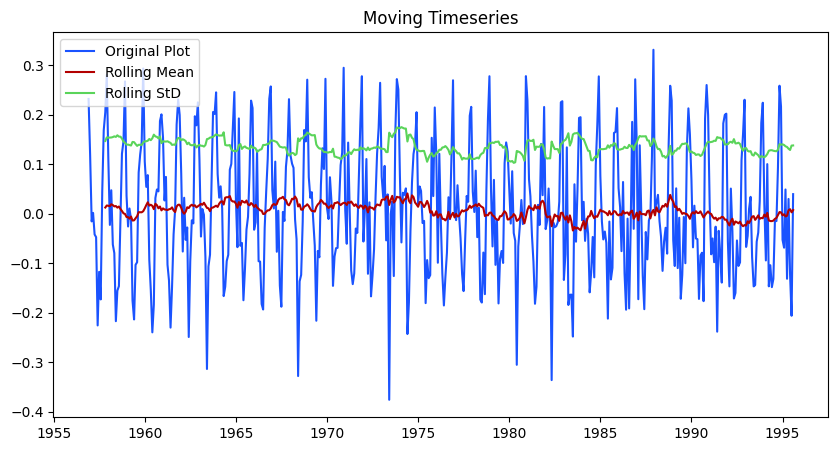

In [22]:
# Check for stationarity
adf_tester(detrend_df)

## Decomposition

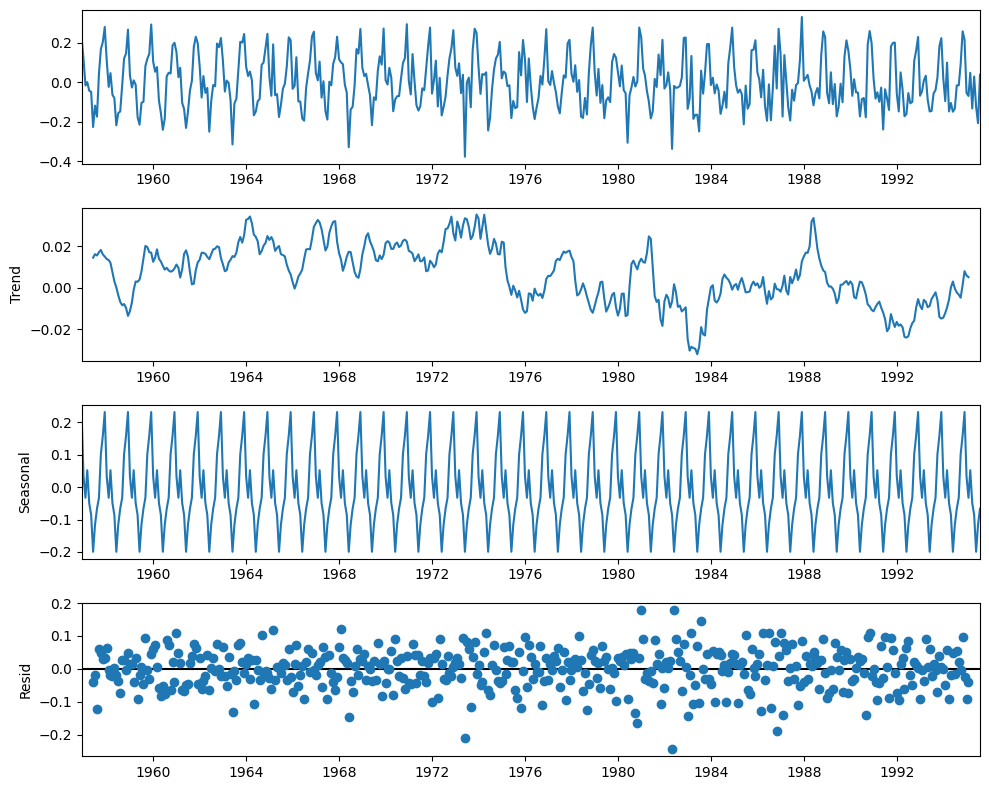

In [23]:
# seasonal decomposition
df_season = seasonal_decompose(detrend_df,model='additive')
rcParams['figure.figsize']=10,8
df_season.plot()
plt.show()

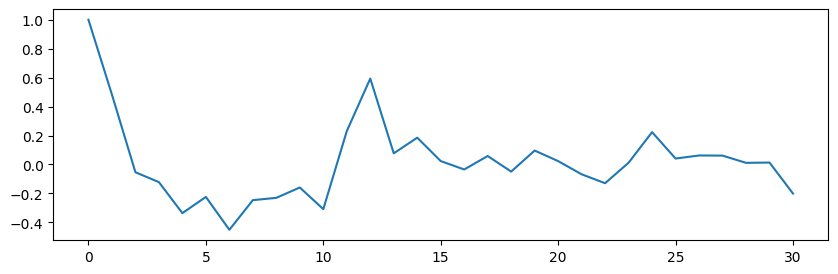

In [24]:
# partical correlation function
df_pacf = pacf(detrend_df,nlags=30)
plt.figure(figsize=(10,3))
plt.plot(df_pacf)
plt.show()

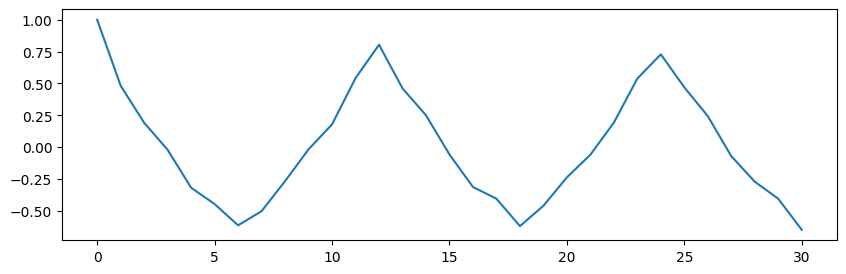

In [25]:
# autocorrelation function
df_acf = acf(detrend_df,nlags=30)
plt.figure(figsize=(10,3))
plt.plot(df_acf)
plt.show()

## Forecasting

In [26]:
# set date as index
df = df.set_index(['Date'])
# new df
df.head(3)

,Monthly beer production,Month,Year
Date,,,
1956-01-01,93.2,1,1956
1956-02-01,96.0,2,1956
1956-03-01,95.2,3,1956


In [27]:
# split data to train and test
split_time = '1984-12-01'
# train and test data
df_train = df.loc[df.index <= split_time].copy()
df_test = df.loc[df.index > split_time].copy()

In [28]:
# data division
def split(df, label=None):
  X =df[['Month','Year']]
  if label:
    y = df[label]
    return X, y
  return X

X_train, y_train = split(df_train, label='Monthly beer production')
X_test, y_test = split(df_test, label='Monthly beer production')

In [ ]:
# Instantiate Xgb regressor to predict forcast
reg = xgb.XGBRegressor(n_estimators=1000)
# train model
reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,verbose=False) 

<Axes: xlabel='Date'>

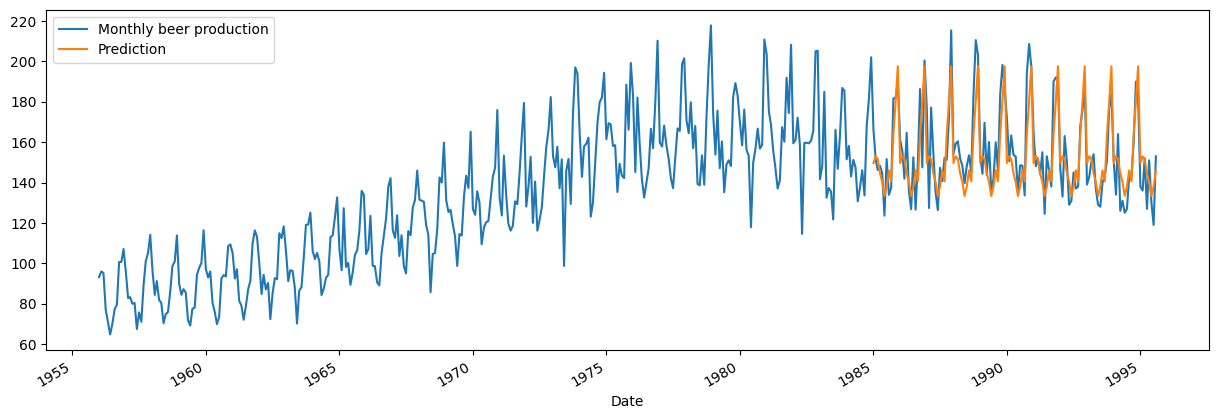

In [30]:
# add prediction column to test set
df_test['Prediction'] = reg.predict(X_test)
# concat(combine) test and train test
df_all = pd.concat([df_test, df_train], sort=False)
# plot concat data
df_all[['Monthly beer production','Prediction']].plot(figsize=(15, 5))

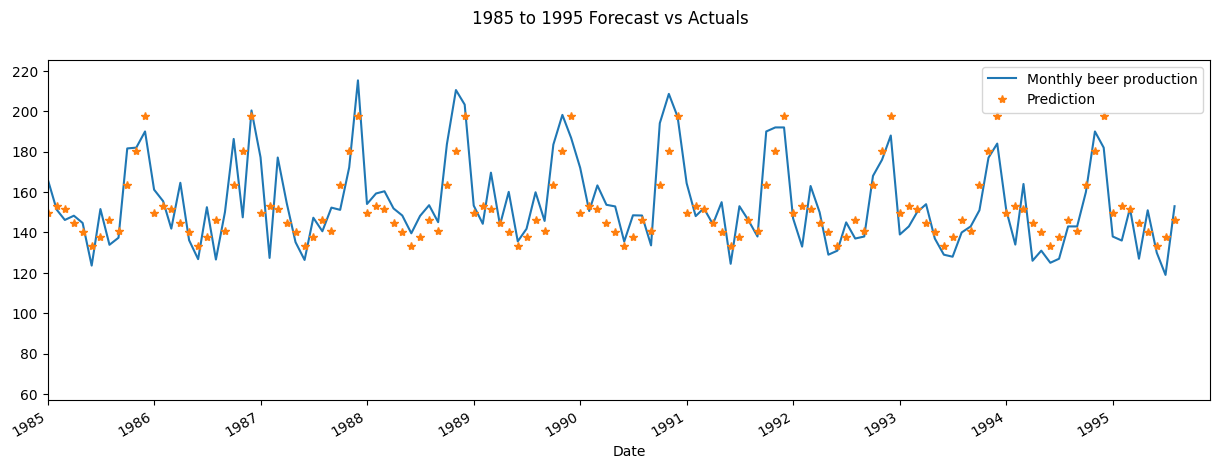

In [31]:
# Plot the forecast with the actuals in test set
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
df_all[['Monthly beer production','Prediction']].plot(ax=ax,style=['-','*'])
ax.set_xbound(lower='1985-01-01', upper='1995-12-01')
plot = plt.suptitle('1985 to 1995 Forecast vs Actuals')